In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px


In [49]:
df = pd.read_csv("datasets\Dyadic_COW_4.0.csv")

<>:1: SyntaxWarning:

invalid escape sequence '\D'

<>:1: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\2554678162.py:1: SyntaxWarning:

invalid escape sequence '\D'



In [50]:
def clean_trade_data(df):
    """
    Analyze and clean trade data based on source codes from documentation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The raw trade data dataframe with source1 and source2 columns
    
    Returns:
    --------
    tuple
        (cleaned_df, quality_report)
        cleaned_df: The cleaned dataframe
        quality_report: Dictionary containing data quality metrics
    """
    # Initialize quality report
    quality_report = {
        'original_rows': len(df),
        'source_codes': {
            '-9': {'count': 0, 'description': 'Missing data'},
            '1': {'count': 0, 'description': 'Barbieri Version 1'},
            '2': {'count': 0, 'description': 'Hicks (2015) Imports'},
            '2.01': {'count': 0, 'description': 'Revised Hicks Imports'},
            '2.1': {'count': 0, 'description': "Hicks (2015) Exporter's report"},
            '2.11': {'count': 0, 'description': "Revised Hicks Exporter's report"},
            '3': {'count': 0, 'description': 'IMF import reports (2015)'},
            '4': {'count': 0, 'description': 'Missing imports replaced with IMF exports'},
            '5': {'count': 0, 'description': "Zero trade replaced with IMF's exports"},
            '6': {'count': 0, 'description': 'COW 4.0 replaced with COW 3.0'}
        },
        'yearly_stats': {},
        'cleaning_steps': [],
        'data_sources': {}
    }
    
    # Create a copy of the dataframe to clean
    cleaned_df = df.copy()
    
    # Step 1: Count occurrences of each source code
    for source in ['source1', 'source2']:  # Check both source columns
        if source in cleaned_df.columns:
            for code in quality_report['source_codes'].keys():
                code_float = float(code)
                count = (cleaned_df[source] == code_float).sum()
                quality_report['source_codes'][code]['count'] += count
    
    # Step 2: Handle missing data (-9)
    missing_mask = (cleaned_df['flow1'] == -9)
    quality_report['cleaning_steps'].append(
        f"Found {missing_mask.sum()} rows with missing data (code -9)"
    )
    
    # Step 3: Analyze data sources by year
    years = sorted(cleaned_df['year'].unique())
    for year in years:
        year_data = cleaned_df[cleaned_df['year'] == year]
        quality_report['yearly_stats'][year] = {
            'total_entries': len(year_data),
            'missing_data': (year_data['flow1'] == -9).sum(),
            'source_distribution': {
                'source1': year_data['source1'].value_counts().to_dict(),
                'source2': year_data['source2'].value_counts().to_dict() if 'source2' in year_data.columns else {}
            },
            'countries': len(set(year_data['importer1'].unique()) | 
                           set(year_data['importer2'].unique()))
        }
    
    # Step 4: Remove missing data
    cleaned_df = cleaned_df[~missing_mask]
    
    # Step 5: Flag potentially problematic data
    # Data where source codes indicate replacements or revisions
    replacement_sources = [4, 5, 6]  # Sources that indicate data replacement
    revised_sources = [2.01, 2.11]   # Sources that indicate revised data
    
    for source in ['source1', 'source2']:
        if source in cleaned_df.columns:
            replacement_mask = cleaned_df[source].isin(replacement_sources)
            revised_mask = cleaned_df[source].isin(revised_sources)
            
            quality_report['cleaning_steps'].append(
                f"Found {replacement_mask.sum()} rows with replaced data in {source}"
            )
            quality_report['cleaning_steps'].append(
                f"Found {revised_mask.sum()} rows with revised data in {source}"
            )
    
    # Step 6: Final statistics
    quality_report['final_rows'] = len(cleaned_df)
    quality_report['rows_removed'] = quality_report['original_rows'] - quality_report['final_rows']
    quality_report['removal_percentage'] = (quality_report['rows_removed'] / quality_report['original_rows']) * 100
    
    return cleaned_df, quality_report



In [51]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_quality_report(df, quality_report):
    """
    Create interactive visualizations and analysis of the data quality report
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The original trade data
    quality_report : dict
        The quality report from clean_trade_data function
    """
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Distribution of Source Codes Over Time',
            'Data Completeness by Year',
            'Number of Trading Countries by Year',
            'Source Code Distribution'
        )
    )
    
    # 1. Source codes over time
    years = sorted(quality_report['yearly_stats'].keys())
    sources = {}
    
    # Collect data for each year
    for year in years:
        for source_type in ['source1', 'source2']:
            if source_type in quality_report['yearly_stats'][year]['source_distribution']:
                dist = quality_report['yearly_stats'][year]['source_distribution'][source_type]
                for source, count in dist.items():
                    if source not in sources:
                        sources[source] = []
                    while len(sources[source]) < len(years):
                        sources[source].append(0)
                    sources[source][-1] += count

    # Plot source code distribution over time
    for source, counts in sources.items():
        fig.add_trace(
            go.Scatter(
                x=years,
                y=counts,
                name=f'Source {source}',
                mode='lines',
                hovertemplate='Year: %{x}<br>Count: %{y}'
            ),
            row=1, col=1
        )

    # 2. Data completeness by year
    complete_data = []
    missing_data = []
    
    for year in years:
        stats = quality_report['yearly_stats'][year]
        total = stats['total_entries']
        missing = stats['missing_data']
        complete_data.append(total - missing)
        missing_data.append(missing)
    
    fig.add_trace(
        go.Bar(
            x=years,
            y=complete_data,
            name='Complete Data',
            marker_color='green'
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(
            x=years,
            y=missing_data,
            name='Missing Data',
            marker_color='red'
        ),
        row=1, col=2
    )

    # 3. Number of trading countries by year
    countries_count = [stats['countries'] for stats in quality_report['yearly_stats'].values()]
    
    fig.add_trace(
        go.Scatter(
            x=years,
            y=countries_count,
            mode='lines+markers',
            name='Trading Countries',
            line=dict(color='blue')
        ),
        row=2, col=1
    )

    # 4. Overall source code distribution
    source_codes = list(quality_report['source_codes'].keys())
    source_counts = [quality_report['source_codes'][code]['count'] for code in source_codes]
    source_desc = [quality_report['source_codes'][code]['description'] for code in source_codes]
    
    fig.add_trace(
        go.Bar(
            x=source_codes,
            y=source_counts,
            text=source_desc,
            hovertemplate='Code: %{x}<br>Count: %{y}<br>Description: %{text}',
            name='Source Codes'
        ),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        title_text="Trade Data Quality Analysis",
        showlegend=True,
        barmode='stack'
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_xaxes(title_text="Year", row=2, col=1)
    fig.update_xaxes(title_text="Source Code", row=2, col=2)
    
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Number of Entries", row=1, col=2)
    fig.update_yaxes(title_text="Number of Countries", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=2)
    
    fig.show()
    
    # Print summary statistics
    print("\n=== Data Quality Summary ===")
    print(f"Total rows analyzed: {quality_report['original_rows']}")
    print(f"Rows after cleaning: {quality_report['final_rows']}")
    print(f"Rows removed: {quality_report['rows_removed']} ({quality_report['removal_percentage']:.2f}%)")
    
    print("\nSource Code Distribution:")
    for code, info in quality_report['source_codes'].items():
        if info['count'] > 0:
            print(f"Code {code}: {info['count']} entries - {info['description']}")
    
    # Return cleaned dataset statistics
    return {
        'years_covered': len(years),
        'start_year': min(years),
        'end_year': max(years),
        'total_countries': len(set(df['importer1'].unique()) | set(df['importer2'].unique())),
        'data_completeness': (quality_report['final_rows'] / quality_report['original_rows']) * 100
    }



# Clean the data
cleaned_df, quality_report = clean_trade_data(df)

# Analyze and visualize the quality report
stats = analyze_quality_report(df, quality_report)

# Use the cleaned data for further analysis
print("\n=== Cleaned Dataset Statistics ===")
print(f"Years covered: {stats['years_covered']} ({stats['start_year']}-{stats['end_year']})")
print(f"Total countries: {stats['total_countries']}")
print(f"Data completeness: {stats['data_completeness']:.2f}%")

# Save the cleaned data if needed
# cleaned_df.to_csv('cleaned_trade_data.csv', index=False)


=== Data Quality Summary ===
Total rows analyzed: 886828
Rows after cleaning: 650717
Rows removed: 236111 (26.62%)

Source Code Distribution:
Code -9: 480893 entries - Missing data
Code 1: 78821 entries - Barbieri Version 1
Code 2: 19076 entries - Hicks (2015) Imports
Code 2.01: 233 entries - Revised Hicks Imports
Code 3: 1022770 entries - IMF import reports (2015)
Code 4: 92681 entries - Missing imports replaced with IMF exports
Code 5: 44899 entries - Zero trade replaced with IMF's exports
Code 6: 25097 entries - COW 4.0 replaced with COW 3.0

=== Cleaned Dataset Statistics ===
Years covered: 145 (1870-2014)
Total countries: 207
Data completeness: 73.38%


In [53]:
df = cleaned_df

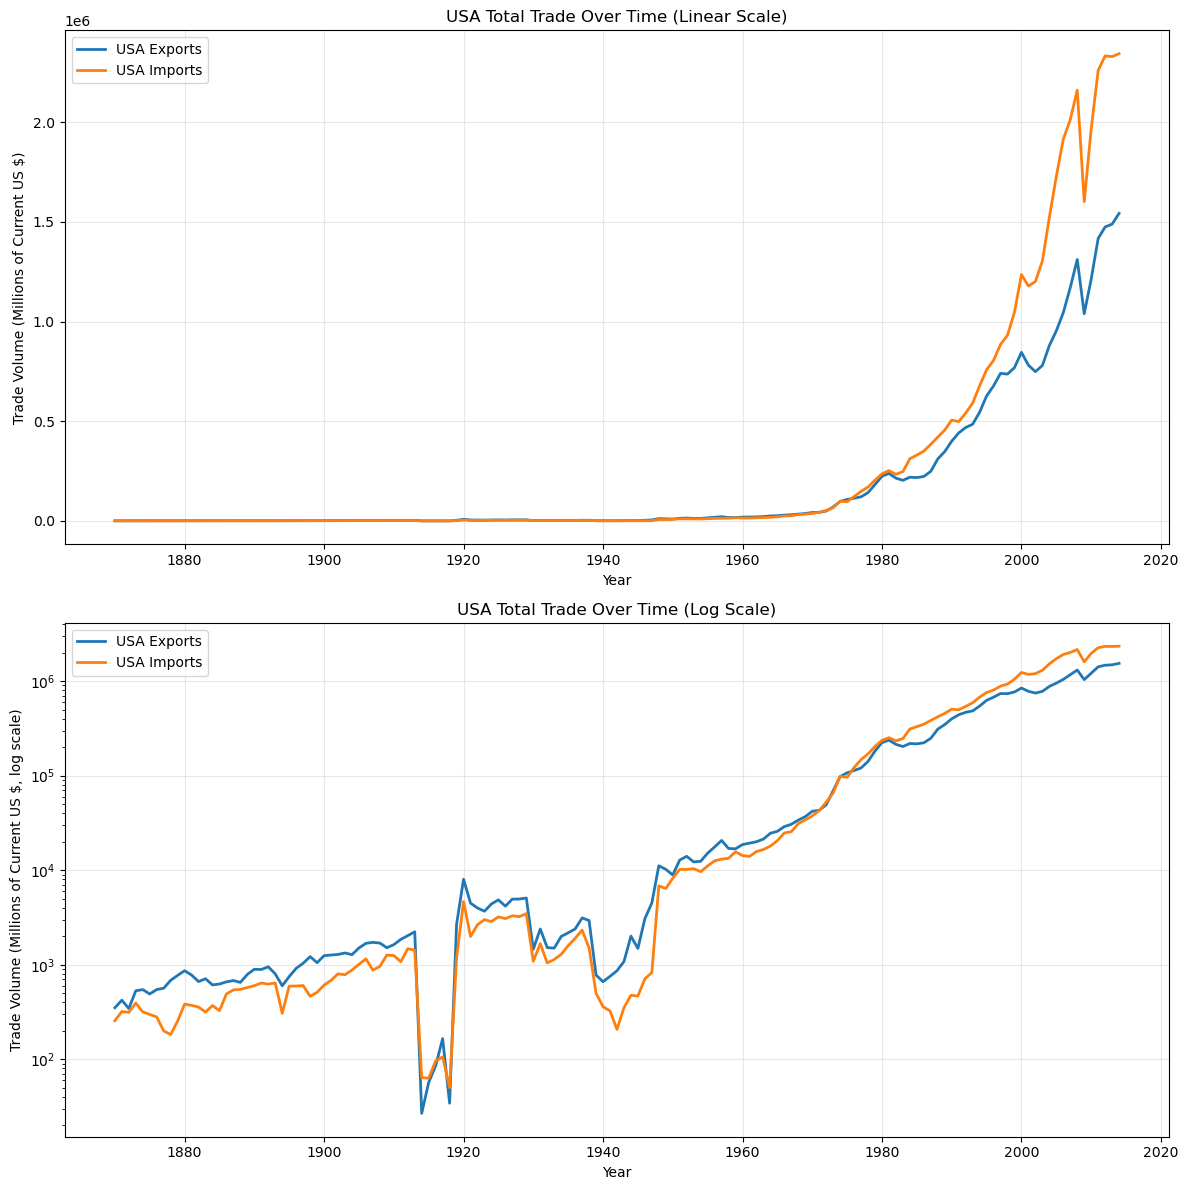


Trade Statistics (in millions of current US $):
Latest year: 2014
Latest exports: 1,542,920.83
Latest imports: 2,344,004.52
Trade balance: -801,083.69


In [54]:
def plot_usa_trade():
    # USA's imports: sum of flow1 when USA is ccode1 and flow2 when USA is ccode2
    usa_imports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow1'].sum()
    usa_imports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow2'].sum()
    usa_total_imports = usa_imports_as_ccode1.add(usa_imports_as_ccode2, fill_value=0)

    # USA's exports: sum of flow2 when USA is ccode1 and flow1 when USA is ccode2
    usa_exports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow2'].sum()
    usa_exports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow1'].sum()
    usa_total_exports = usa_exports_as_ccode1.add(usa_exports_as_ccode2, fill_value=0)

    # Create figure with two subplots: linear and log scale
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Linear scale plot
    ax1.plot(usa_total_exports.index, usa_total_exports.values, label='USA Exports', linewidth=2)
    ax1.plot(usa_total_imports.index, usa_total_imports.values, label='USA Imports', linewidth=2)
    ax1.set_title('USA Total Trade Over Time (Linear Scale)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Trade Volume (Millions of Current US $)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Log scale plot
    ax2.plot(usa_total_exports.index, usa_total_exports.values, label='USA Exports', linewidth=2)
    ax2.plot(usa_total_imports.index, usa_total_imports.values, label='USA Imports', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('USA Total Trade Over Time (Log Scale)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Trade Volume (Millions of Current US $, log scale)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nTrade Statistics (in millions of current US $):")
    print(f"Latest year: {usa_total_exports.index[-1]}")
    print(f"Latest exports: {usa_total_exports.values[-1]:,.2f}")
    print(f"Latest imports: {usa_total_imports.values[-1]:,.2f}")
    print(f"Trade balance: {(usa_total_exports.values[-1] - usa_total_imports.values[-1]):,.2f}")

plot_usa_trade()

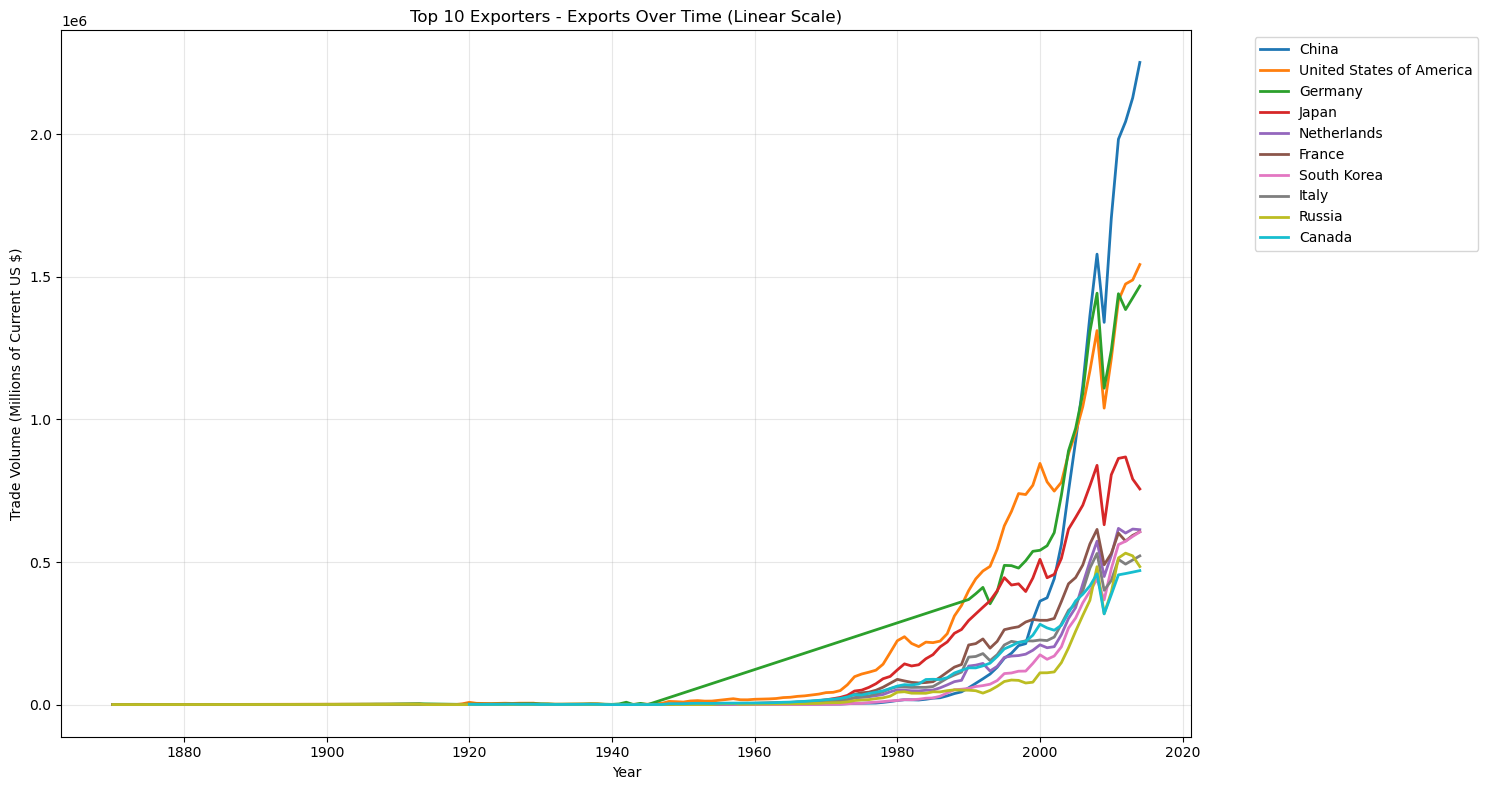

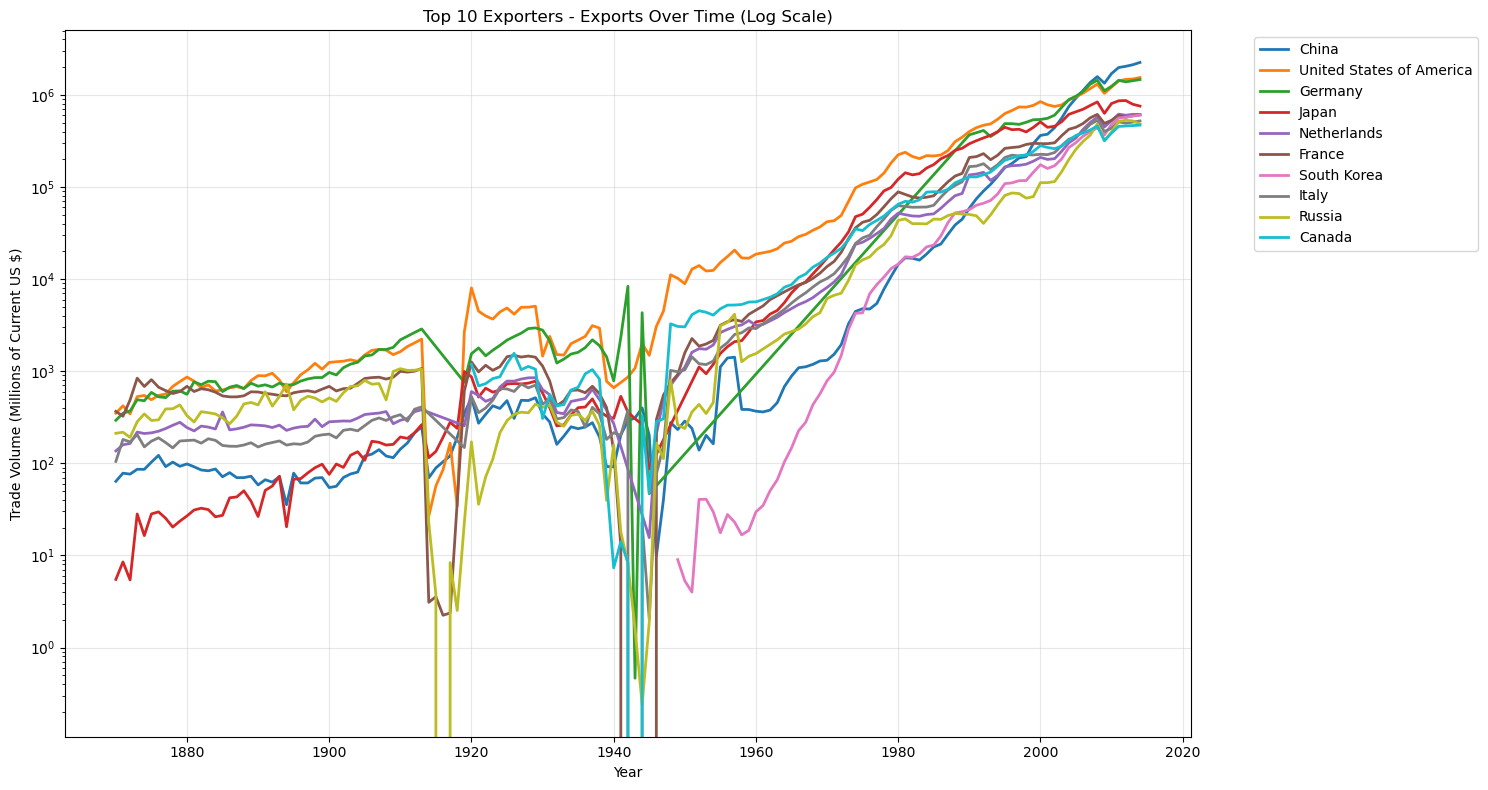

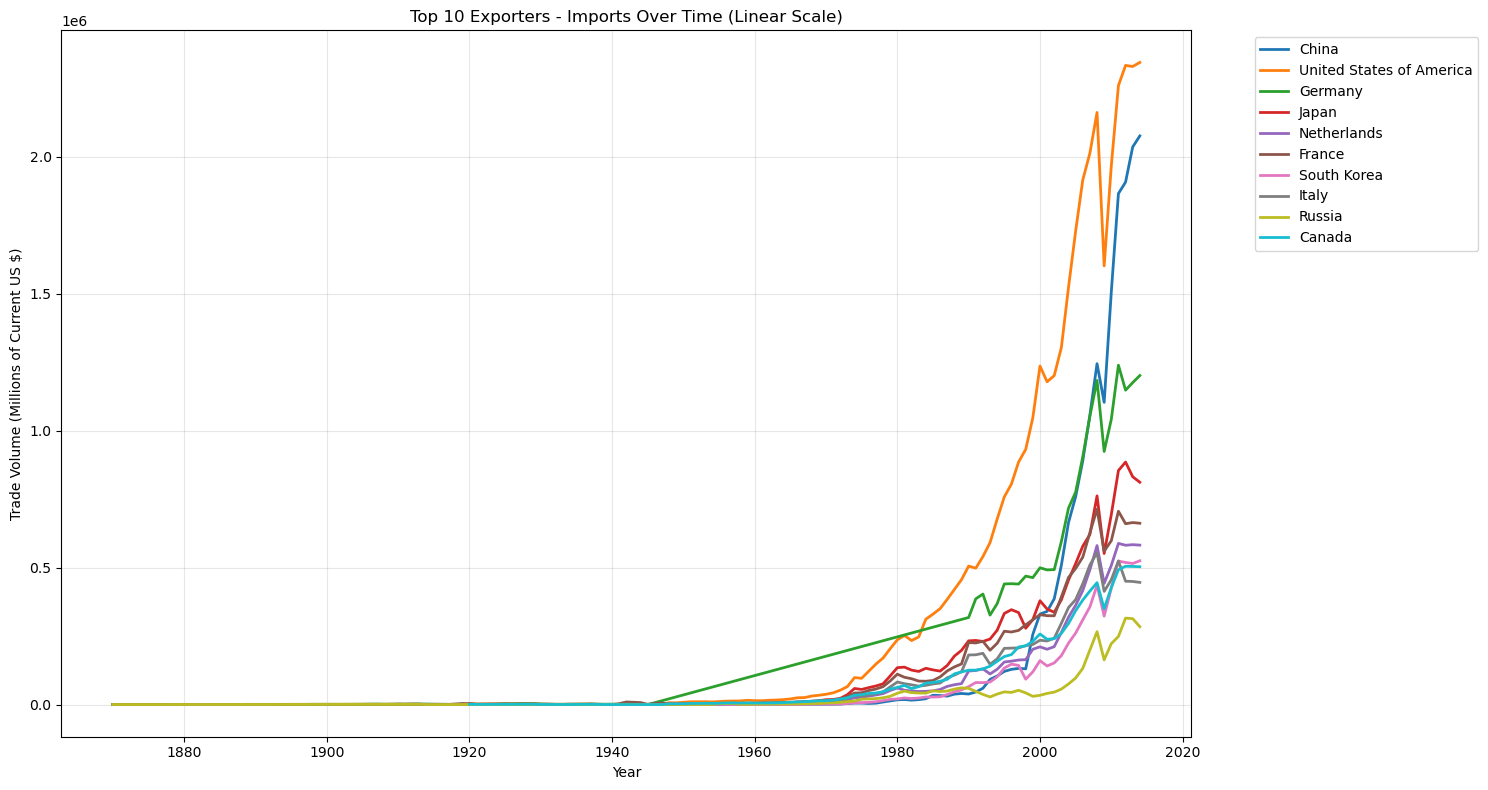

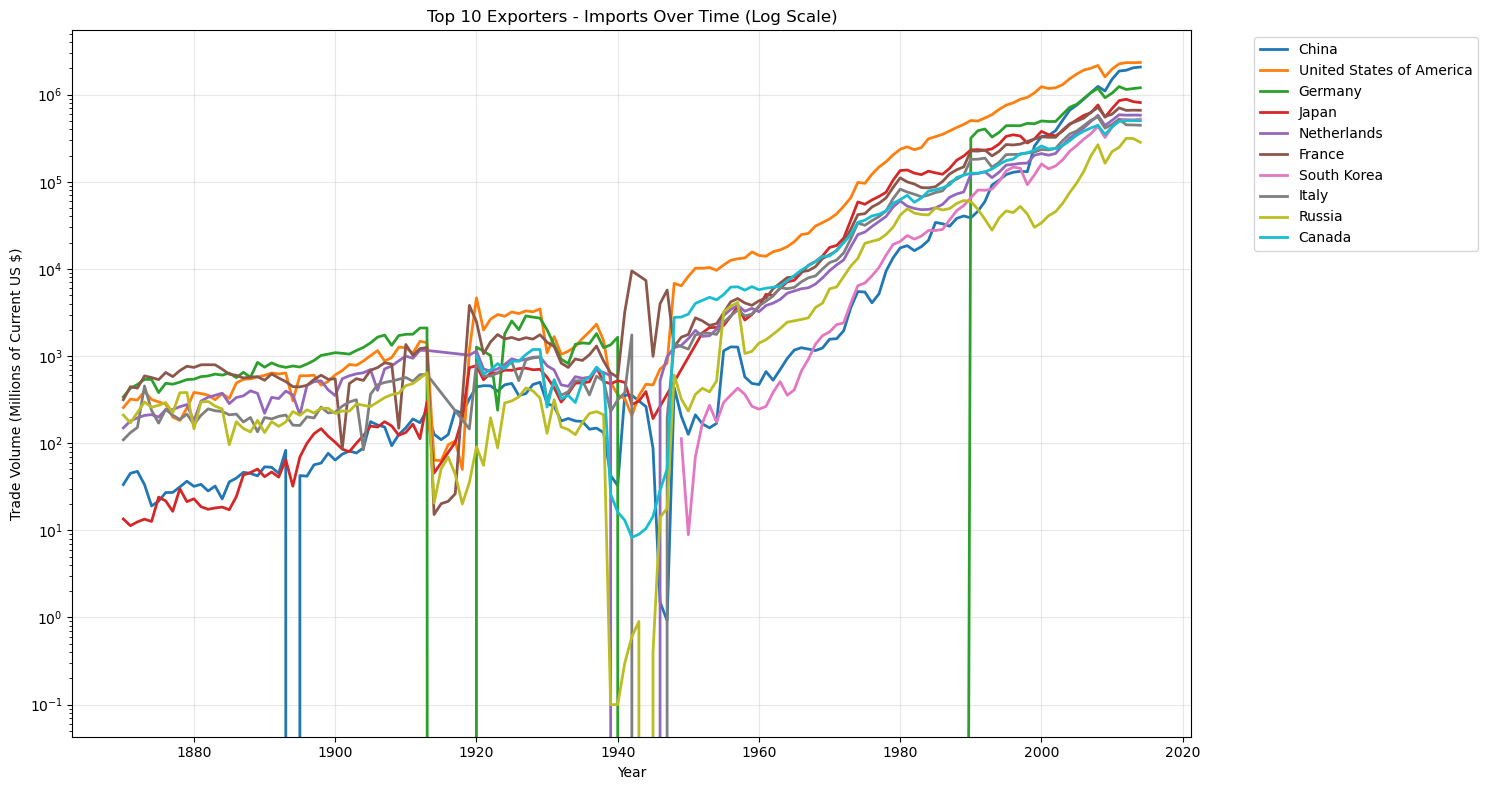


Top 10 Exporters Statistics (in millions of current US $):

China:
Exports: 2,251,540.55
Imports: 2,075,854.44
Trade balance: 175,686.11

United States of America:
Exports: 1,542,920.83
Imports: 2,344,004.52
Trade balance: -801,083.69

Germany:
Exports: 1,467,678.47
Imports: 1,201,134.86
Trade balance: 266,543.61

Japan:
Exports: 756,108.60
Imports: 811,605.97
Trade balance: -55,497.37

Netherlands:
Exports: 613,214.73
Imports: 582,049.83
Trade balance: 31,164.90

France:
Exports: 606,067.54
Imports: 661,923.41
Trade balance: -55,855.86

South Korea:
Exports: 605,367.98
Imports: 524,847.17
Trade balance: 80,520.81

Italy:
Exports: 521,434.24
Imports: 446,032.43
Trade balance: 75,401.81

Russia:
Exports: 483,949.82
Imports: 284,392.19
Trade balance: 199,557.63

Canada:
Exports: 469,807.34
Imports: 503,314.35
Trade balance: -33,507.01


C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:93: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:94: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:93: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:94: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:93: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:94: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Magnus\AppData\Local\Temp\ipykernel_10120\538580332.py:93: UserWarning:

Boolean Series key will be reindexed to ma

In [55]:
def plot_top_exporters():
    # Get the latest year in the dataset
    latest_year = df["year"].max()

    # Calculate total exports for each country in the latest year
    # For each country, sum both their exports as ccode1 (flow2) and as ccode2 (flow1)
    latest_exports_as_ccode1 = df[df["year"] == latest_year].groupby("ccode1")["flow2"].sum()
    latest_exports_as_ccode2 = df[df["year"] == latest_year].groupby("ccode2")["flow1"].sum()
    latest_total_exports = latest_exports_as_ccode1.add(latest_exports_as_ccode2, fill_value=0)
    
    # Get country names for the codes
    country_names = {}
    for code in latest_total_exports.index:
        # Get name from either importer1 or importer2 where the code matches
        name = df[df["ccode1"] == code]["importer1"].iloc[0] if len(df[df["ccode1"] == code]) > 0 else df[df["ccode2"] == code]["importer2"].iloc[0]
        country_names[code] = name

    # Get top 10 exporters by code
    top_10_exporter_codes = latest_total_exports.nlargest(10).index

    # Create four separate figures
    plt.figure(figsize=(15,8))
    # Plot exports linear scale
    for code in top_10_exporter_codes:
        exports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow2"].sum()
        exports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow1"].sum()
        total_exports = exports_as_ccode1.add(exports_as_ccode2, fill_value=0)
        plt.plot(total_exports.index, total_exports.values, label=country_names[code], linewidth=2)
    
    plt.title("Top 10 Exporters - Exports Over Time (Linear Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot exports log scale
    for code in top_10_exporter_codes:
        exports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow2"].sum()
        exports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow1"].sum()
        total_exports = exports_as_ccode1.add(exports_as_ccode2, fill_value=0)
        plt.plot(total_exports.index, total_exports.values, label=country_names[code], linewidth=2)
    
    plt.yscale('log')
    plt.title("Top 10 Exporters - Exports Over Time (Log Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot imports linear scale
    for code in top_10_exporter_codes:
        imports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow1"].sum()
        imports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow2"].sum()
        total_imports = imports_as_ccode1.add(imports_as_ccode2, fill_value=0)
        plt.plot(total_imports.index, total_imports.values, label=country_names[code], linewidth=2)
    
    plt.title("Top 10 Exporters - Imports Over Time (Linear Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,8))
    # Plot imports log scale
    for code in top_10_exporter_codes:
        imports_as_ccode1 = df[df["ccode1"] == code].groupby("year")["flow1"].sum()
        imports_as_ccode2 = df[df["ccode2"] == code].groupby("year")["flow2"].sum()
        total_imports = imports_as_ccode1.add(imports_as_ccode2, fill_value=0)
        plt.plot(total_imports.index, total_imports.values, label=country_names[code], linewidth=2)
    
    plt.yscale('log')
    plt.title("Top 10 Exporters - Imports Over Time (Log Scale)")
    plt.xlabel("Year")
    plt.ylabel("Trade Volume (Millions of Current US $)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print statistics for top exporters
    print("\nTop 10 Exporters Statistics (in millions of current US $):")
    for code in top_10_exporter_codes:
        name = country_names[code]
        exports = latest_total_exports[code]
        imports_as_ccode1 = df[df["year"] == latest_year][df["ccode1"] == code]["flow1"].sum()
        imports_as_ccode2 = df[df["year"] == latest_year][df["ccode2"] == code]["flow2"].sum()
        total_imports = imports_as_ccode1 + imports_as_ccode2
        print(f"\n{name}:")
        print(f"Exports: {exports:,.2f}")
        print(f"Imports: {total_imports:,.2f}")
        print(f"Trade balance: {exports - total_imports:,.2f}")
plot_top_exporters()

In [56]:
def plot_trade_network(df,year = 1920):
    # Filter data for 1920
    df = df[df["year"] == year]

    # Create directed graph
    G = nx.DiGraph()

    # Add edges with weights
    for _, row in df.iterrows():
        if row["flow1"] > 0:  # Only add significant trade flows
            G.add_edge(
                row["importer1"], row["importer2"], weight=row["flow1"] / 1000
            )  # Scale down weights for better visualization

    # Calculate node sizes based on total trade volume
    node_sizes = []
    for node in G.nodes():
        total_trade = sum(
            [G[node][neighbor]["weight"] for neighbor in G.neighbors(node)]
        )
        node_sizes.append(total_trade)

    # Normalize node sizes
    node_sizes = np.array(node_sizes)
    node_sizes = (
        1000
        + (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min()) * 9000
    )

    # Create the plot
    plt.figure(figsize=(15, 15))

    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, arrows=True, arrowsize=10)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Global Trade Network - " + str(year))
    plt.axis("off")

    # Save the plot
    # plt.savefig("_visualizations/trade_network_1920.png", dpi=300, bbox_inches="tight")
    # plt.close()
    plt.show()



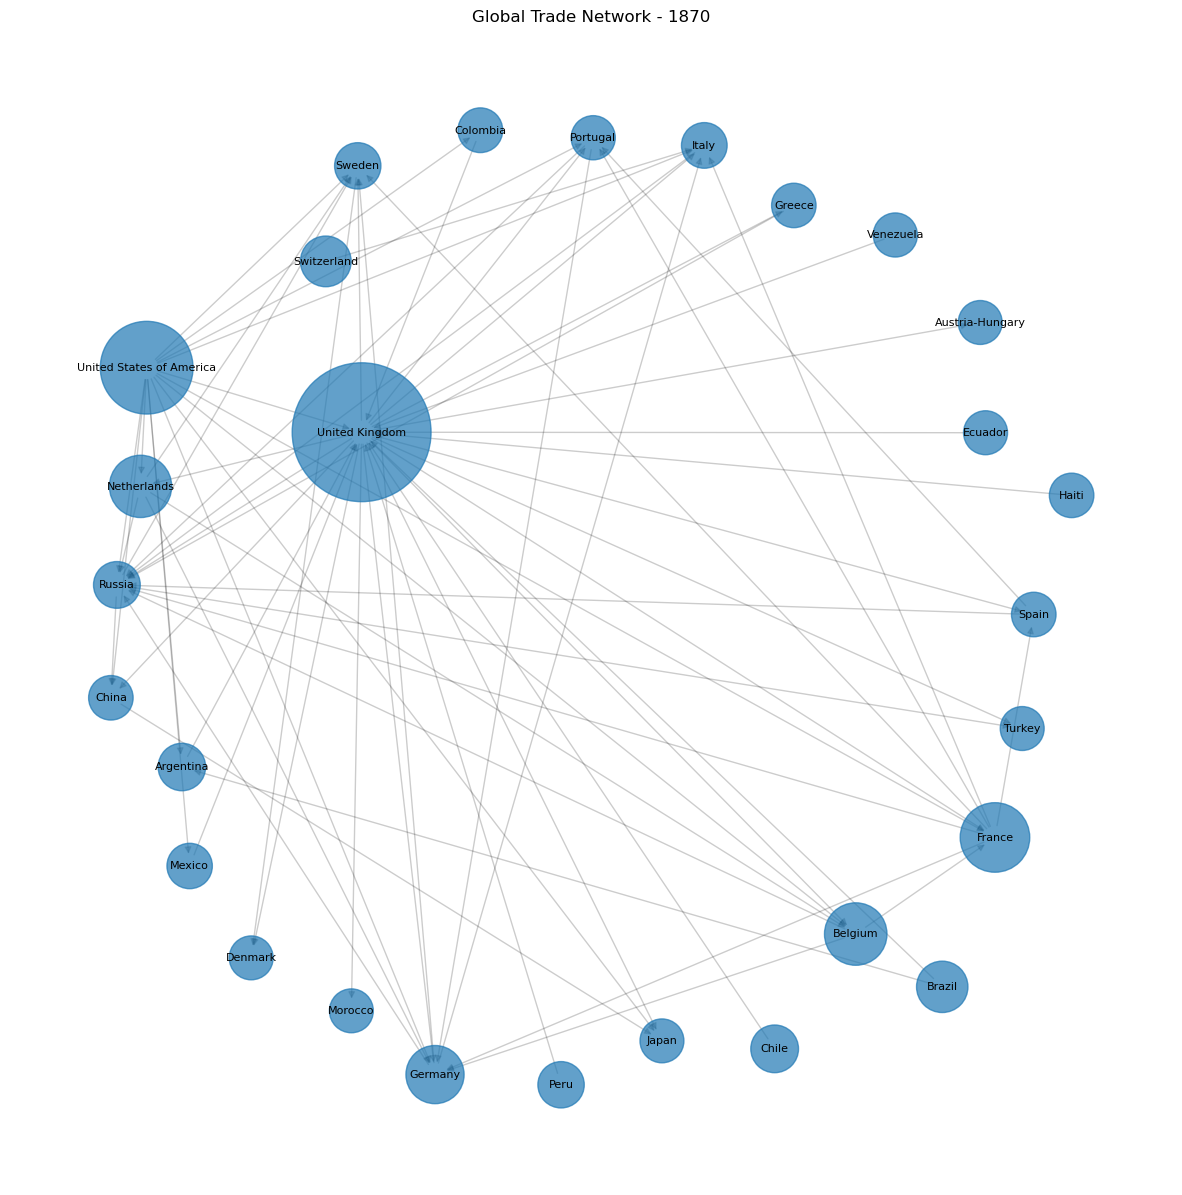

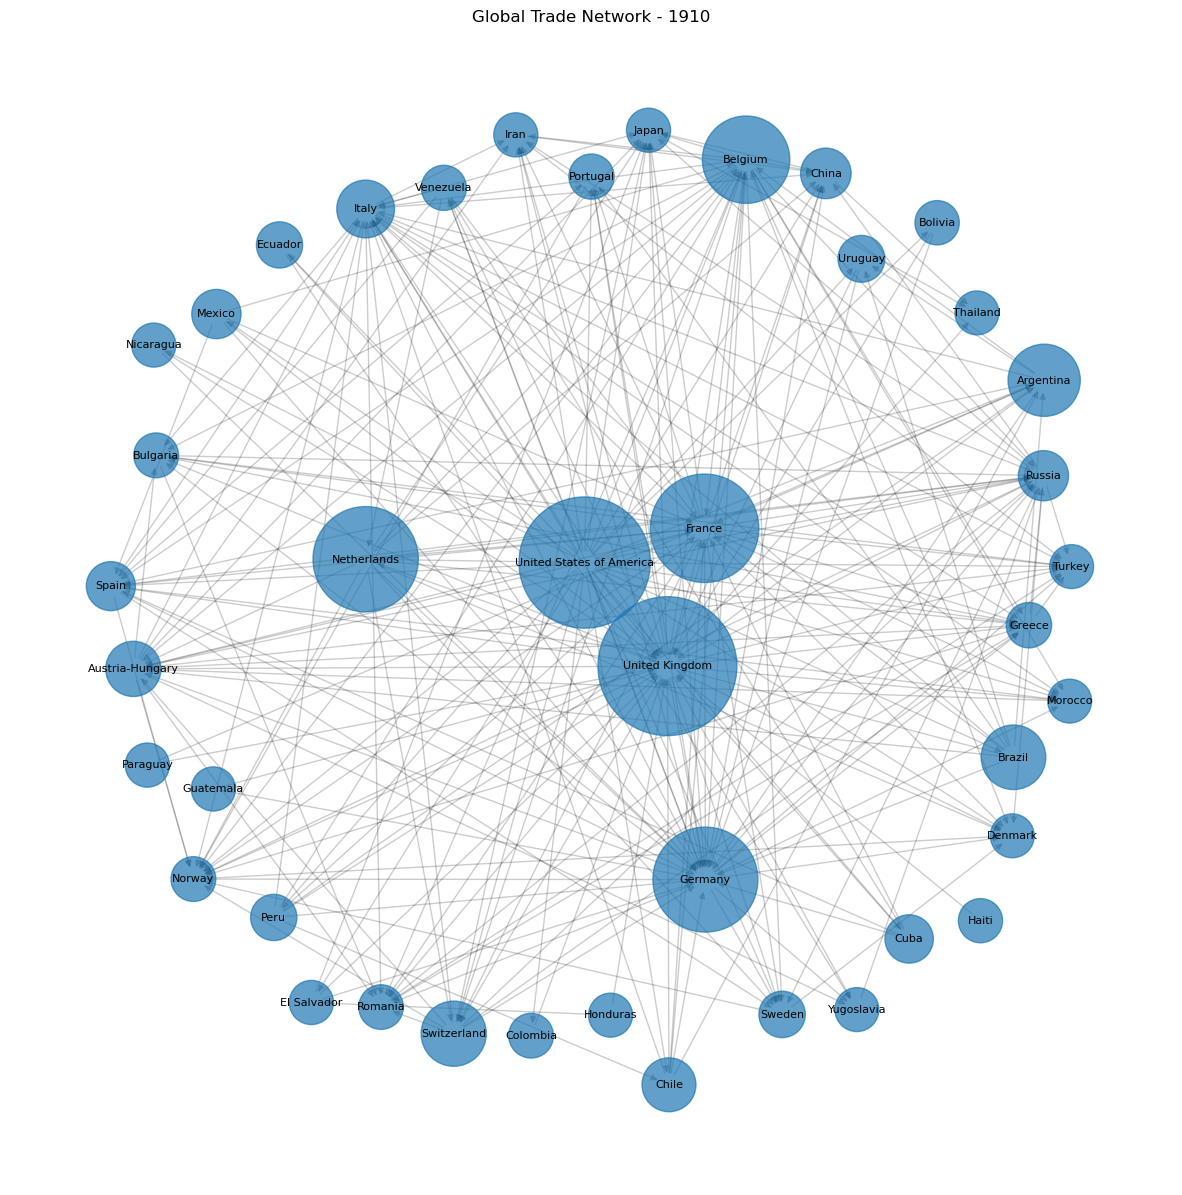

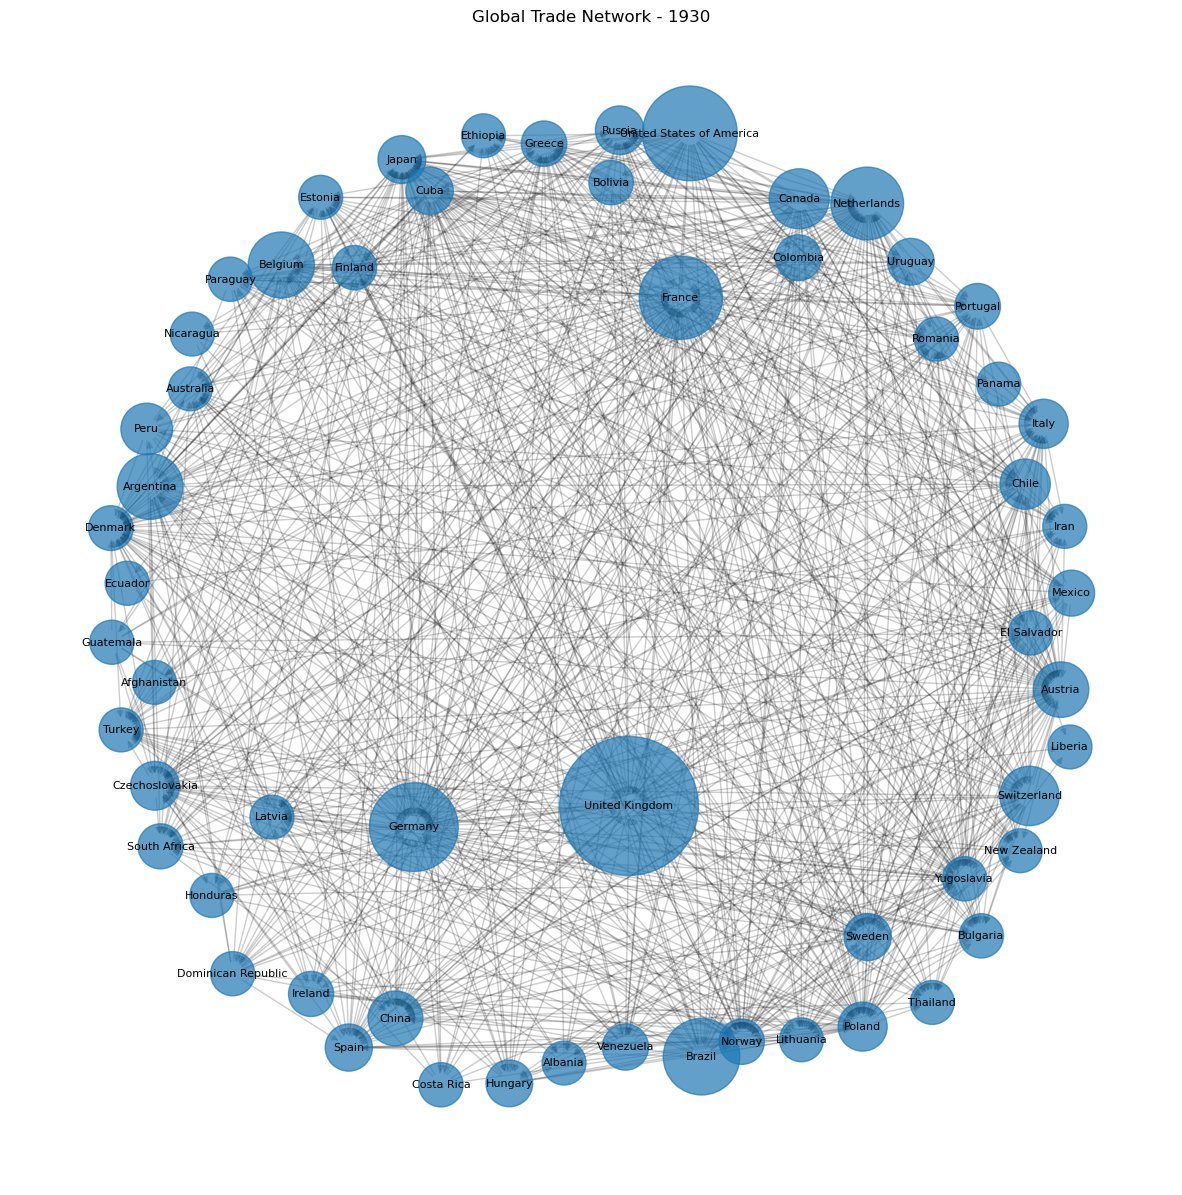

In [57]:
plot_trade_network(df,1870)
plot_trade_network(df,1910)
plot_trade_network(df,1930)
# plot_trade_network(df,1950)
# plot_trade_network(df,1980)
# plot_trade_network(df,2000)
# plot_trade_network(df,2014)

# plot_trade_network(2014)

In [58]:
import wbdata
indicators = {'NY.GDP.MKTP.KD': 'GDP'}
    
    # Get data for USA
data = wbdata.get_dataframe(indicators, country=['USA'])

In [59]:
data

GDP
date              
2023  2.206258e+13
2022  2.144339e+13
2021  2.091785e+13
2020  1.972358e+13
2019  2.015964e+13
...            ...
1964  4.113637e+12
1963  3.888125e+12
1962  3.724258e+12
1961  3.510139e+12
1960  3.431221e+12

[64 rows x 1 columns]

In [60]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def load_and_process_gdp():
    # World Bank indicator for GDP (constant 2015 US$)
    indicators = {'NY.GDP.MKTP.KD': 'GDP'}
    
    # Get data for USA
    data = wbdata.get_dataframe(indicators, country=['USA'])
    
    # Clean and process the data
    gdp_data = data.reset_index()
    gdp_data['year'] = pd.to_datetime(gdp_data['date']).dt.year
    gdp_data = gdp_data.set_index('year')['GDP']
    
    # Convert to millions to match trade data
    gdp_data = gdp_data / 1e6
    
    return gdp_data



Statistics for 2014:
GDP: $17,771,549.06 million
Total Trade: $3,886,925.35 million
Trade as % of GDP: 21.87%
Exports as % of GDP: 8.68%
Imports as % of GDP: 13.19%


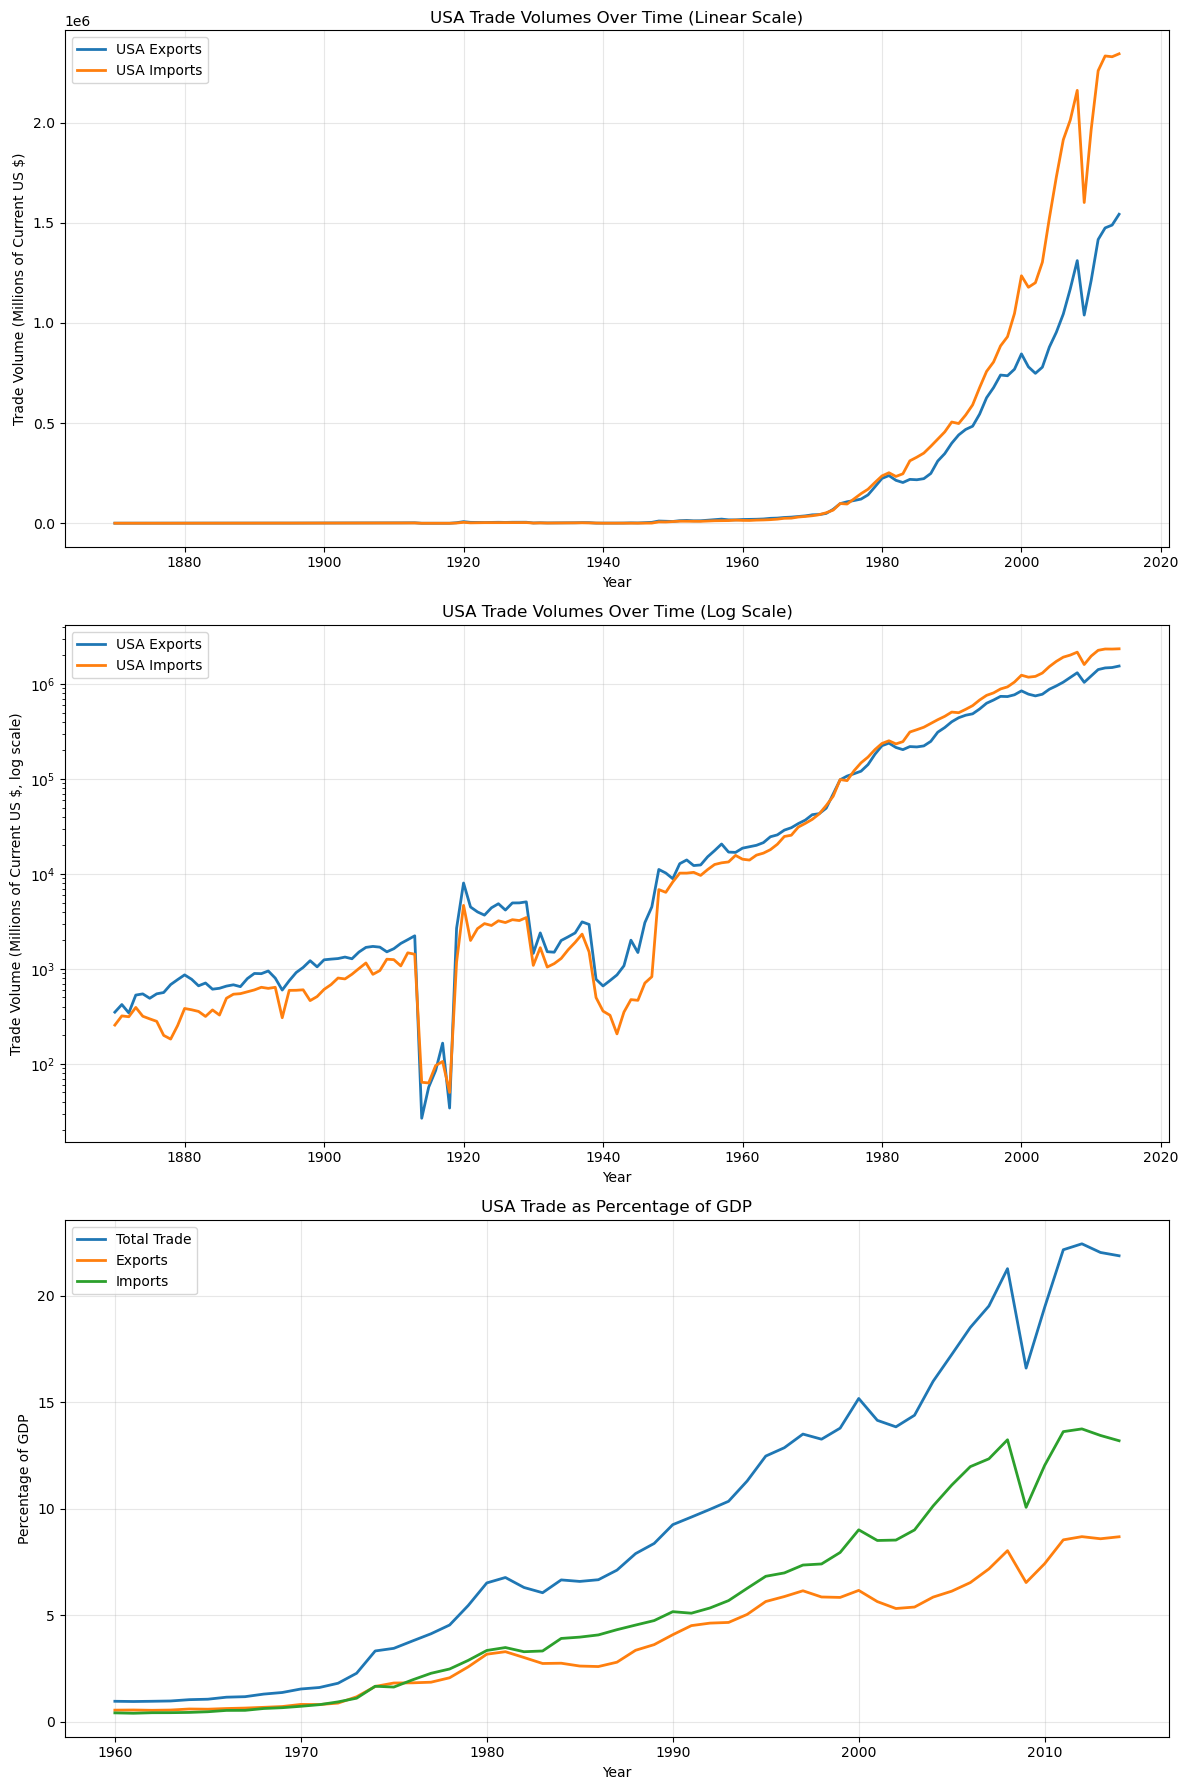

In [61]:

def plot_usa_trade_vs_gdp():
    # Get the trade data
    usa_imports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow1'].sum()
    usa_imports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow2'].sum()
    usa_total_imports = usa_imports_as_ccode1.add(usa_imports_as_ccode2, fill_value=0)

    usa_exports_as_ccode1 = df[df['ccode1'] == 2].groupby('year')['flow2'].sum()
    usa_exports_as_ccode2 = df[df['ccode2'] == 2].groupby('year')['flow1'].sum()
    usa_total_exports = usa_exports_as_ccode1.add(usa_exports_as_ccode2, fill_value=0)

    # Get GDP data
    try:
        gdp_data = load_and_process_gdp()
        has_gdp = True
    except:
        print("Could not fetch GDP data. Plotting trade data only.")
        has_gdp = False

    # Create plots
    if has_gdp:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Plot 1: Trade volumes (linear scale)
    ax1.plot(usa_total_exports.index, usa_total_exports.values, 
            label='USA Exports', linewidth=2)
    ax1.plot(usa_total_imports.index, usa_total_imports.values, 
            label='USA Imports', linewidth=2)
    ax1.set_title('USA Trade Volumes Over Time (Linear Scale)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Trade Volume (Millions of Current US $)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Trade volumes (log scale)
    ax2.plot(usa_total_exports.index, usa_total_exports.values, 
            label='USA Exports', linewidth=2)
    ax2.plot(usa_total_imports.index, usa_total_imports.values, 
            label='USA Imports', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('USA Trade Volumes Over Time (Log Scale)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Trade Volume (Millions of Current US $, log scale)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    if has_gdp:
        # Plot 3: Trade as percentage of GDP
        common_years = usa_total_exports.index.intersection(gdp_data.index)
        total_trade = (usa_total_exports + usa_total_imports)[common_years]
        gdp_aligned = gdp_data[common_years]
        trade_gdp_ratio = (total_trade / gdp_aligned) * 100

        ax3.plot(trade_gdp_ratio.index, trade_gdp_ratio.values, 
                label='Total Trade', linewidth=2)
        ax3.plot(common_years, 
                (usa_total_exports[common_years] / gdp_aligned) * 100,
                label='Exports', linewidth=2)
        ax3.plot(common_years, 
                (usa_total_imports[common_years] / gdp_aligned) * 100,
                label='Imports', linewidth=2)
        ax3.set_title('USA Trade as Percentage of GDP')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Percentage of GDP')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        # Print statistics for the latest common year
        latest_year = common_years[-1]
        print(f"\nStatistics for {latest_year}:")
        print(f"GDP: ${gdp_aligned[latest_year]:,.2f} million")
        print(f"Total Trade: ${total_trade[latest_year]:,.2f} million")
        print(f"Trade as % of GDP: {trade_gdp_ratio[latest_year]:.2f}%")
        print(f"Exports as % of GDP: {(usa_total_exports[latest_year]/gdp_aligned[latest_year]*100):.2f}%")
        print(f"Imports as % of GDP: {(usa_total_imports[latest_year]/gdp_aligned[latest_year]*100):.2f}%")

    plt.tight_layout()
    plt.show()

# First install required package if not already installed
# !pip install wbdata

# Run the analysis
plot_usa_trade_vs_gdp()

In [62]:
def calculate_centralities(G):
    """Calculate various centralities for a graph"""
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    
    # Eigenvector centrality
    # try:
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=10000)
    # except:
    #     # If eigenvector centrality fails, use degree centrality as fallback
    #     eigenvector_centrality = degree_centrality
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'eigenvector': eigenvector_centrality
    }

def calculate_centralities_for_years(df, years=None):
    """
    Calculate centralities for all years in the dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The trade data dataframe
    years : list, optional
        Specific years to calculate centralities for. If None, uses all years in df
    
    Returns:
    --------
    dict
        Dictionary containing centrality measures for each year
    """
    if years is None:
        years = sorted(df['year'].unique())
    
    # Initialize storage for centralities
    centralities = {
        'degree': {},
        'betweenness': {},
        'eigenvector': {}
    }
    
    # Calculate centralities for each year
    for year in tqdm(years):
        # Create graph for this year
        G = nx.DiGraph()
        
        # Add edges with weights
        year_data = df[df['year'] == year]
        for _, row in year_data.iterrows():
            if row['flow1'] > 0:  # Only add significant trade flows
                G.add_edge(row['importer1'], row['importer2'], 
                          weight=row['flow1'])
        
        # Calculate centralities
        year_centralities = calculate_centralities(G)
        
        # Store results
        for centrality_type in centralities:
            centralities[centrality_type][year] = year_centralities[centrality_type]
    
    return centralities

centralities = calculate_centralities_for_years(df)


100%|██████████| 145/145 [01:01<00:00,  2.37it/s]


In [63]:
def get_top_exporters(n=10):
    """Get the top n exporters based on total trade volume"""
    # Calculate total exports for each country
    total_exports = df.groupby('importer1')['flow1'].sum().sort_values(ascending=False)
    return total_exports.head(n).index.tolist()


In [70]:


def plot_country_centralities(countries=None, n_countries=10, centralities=None):
    """
    Plot interactive centrality development for specified countries or top n countries
    
    Parameters:
    -----------
    countries : list, optional
        List of country codes to analyze. If None, uses top n_countries exporters
    n_countries : int, default=10
        Number of top exporters to use if countries is None
    centralities : dict, optional
        Pre-calculated centrality measures. If None, calculates them
    """
    if countries is None:
        countries = get_top_exporters(n_countries)
    
    # Get unique years
    years = sorted(df['year'].unique())
    
    # Calculate centralities if not provided
    if centralities is None:
        centralities = calculate_centralities_for_years(df, years)
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Degree Centrality', 'Normalized Degree Centrality',
            'Betweenness Centrality', 'Normalized Betweenness Centrality',
            'Eigenvector Centrality', 'Normalized Eigenvector Centrality'
        ),
        vertical_spacing=0.1
    )
    
    # Define colors for countries
    colors = px.colors.qualitative.Set1
    
    # Plot each centrality type
    for idx, centrality_type in enumerate(['degree', 'betweenness', 'eigenvector']):
        row = idx + 1
        
        # Plot absolute values
        for country_idx, country in enumerate(countries):
            # Get centrality values for this country over time
            values = [centralities[centrality_type][year].get(country, 0) 
                     for year in years]
            
            fig.add_trace(
                go.Scatter(
                    x=years,
                    y=values,
                    name=country,
                    line=dict(color=colors[country_idx % len(colors)]),
                    showlegend=True if idx == 0 else False,  # Only show legend for first row
                    hovertemplate="<b>%{x}</b><br>" +
                                f"Country: {country}<br>" +
                                f"{centrality_type.capitalize()}: %{{y:.4f}}<br>" +
                                "<extra></extra>"
                ),
                row=row, col=1
            )
        
        # Plot normalized values
        for country_idx, country in enumerate(countries):
            # Calculate normalized values
            values = []
            for year in years:
                # Get all centrality values for this year
                year_values = list(centralities[centrality_type][year].values())
                # Get this country's value
                country_value = centralities[centrality_type][year].get(country, 0)
                # Normalize by sum of all centralities
                total = sum(year_values)
                normalized_value = country_value / total if total > 0 else 0
                values.append(normalized_value)
            
            fig.add_trace(
                go.Scatter(
                    x=years,
                    y=values,
                    name=country,
                    line=dict(color=colors[country_idx % len(colors)]),
                    showlegend=False,
                    hovertemplate="<b>%{x}</b><br>" +
                                f"Country: {country}<br>" +
                                f"Normalized {centrality_type.capitalize()}: %{{y:.4f}}<br>" +
                                "<extra></extra>"
                ),
                row=row, col=2
            )
    
    # Update layout
    fig.update_layout(
        title_text="Network Centrality Development for Selected Countries",
        height=1200,
        width=1200,
        hovermode='x unified',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05
        )
    )
    
    # Update y-axis labels
    for i in range(1, 4):
        fig.update_yaxes(title_text="Centrality Value", row=i, col=1)
        fig.update_yaxes(title_text="Normalized Value", row=i, col=2)
    
    # Update x-axis labels
    for i in range(1, 3):
        fig.update_xaxes(title_text="Year", row=3, col=i)
    
    # Show the plot
    fig.show()
    
    # Print some statistics for the latest year
    latest_year = max(years)
    print("\nCentrality Statistics for Latest Year:")
    for centrality_type in centralities:
        print(f"\n{centrality_type.capitalize()} Centrality:")
        for country in countries:
            value = centralities[centrality_type][latest_year].get(country, 0)
            print(f"{country}: {value:.4f}")

# Example usage:
# Calculate centralities once
# centralities = calculate_centralities_for_years(df)

# Get top 10 exporters and plot their centralities
top_countries = get_top_exporters(3)
plot_country_centralities(countries=top_countries, centralities=centralities)

# Or plot specific countries with the same centrality calculations
# specific_countries = ['USA', 'GBR', 'DEU', 'FRA', 'CHN']
# plot_country_centralities(countries=specific_countries, centralities=centralities)


Centrality Statistics for Latest Year:

Degree Centrality:
United States of America: 0.9784
United Kingdom: 0.9892
China: 0.9946

Betweenness Centrality:
United States of America: 0.0000
United Kingdom: 0.0017
China: 0.0039

Eigenvector Centrality:
United States of America: 0.0000
United Kingdom: 0.0000
China: 0.0000


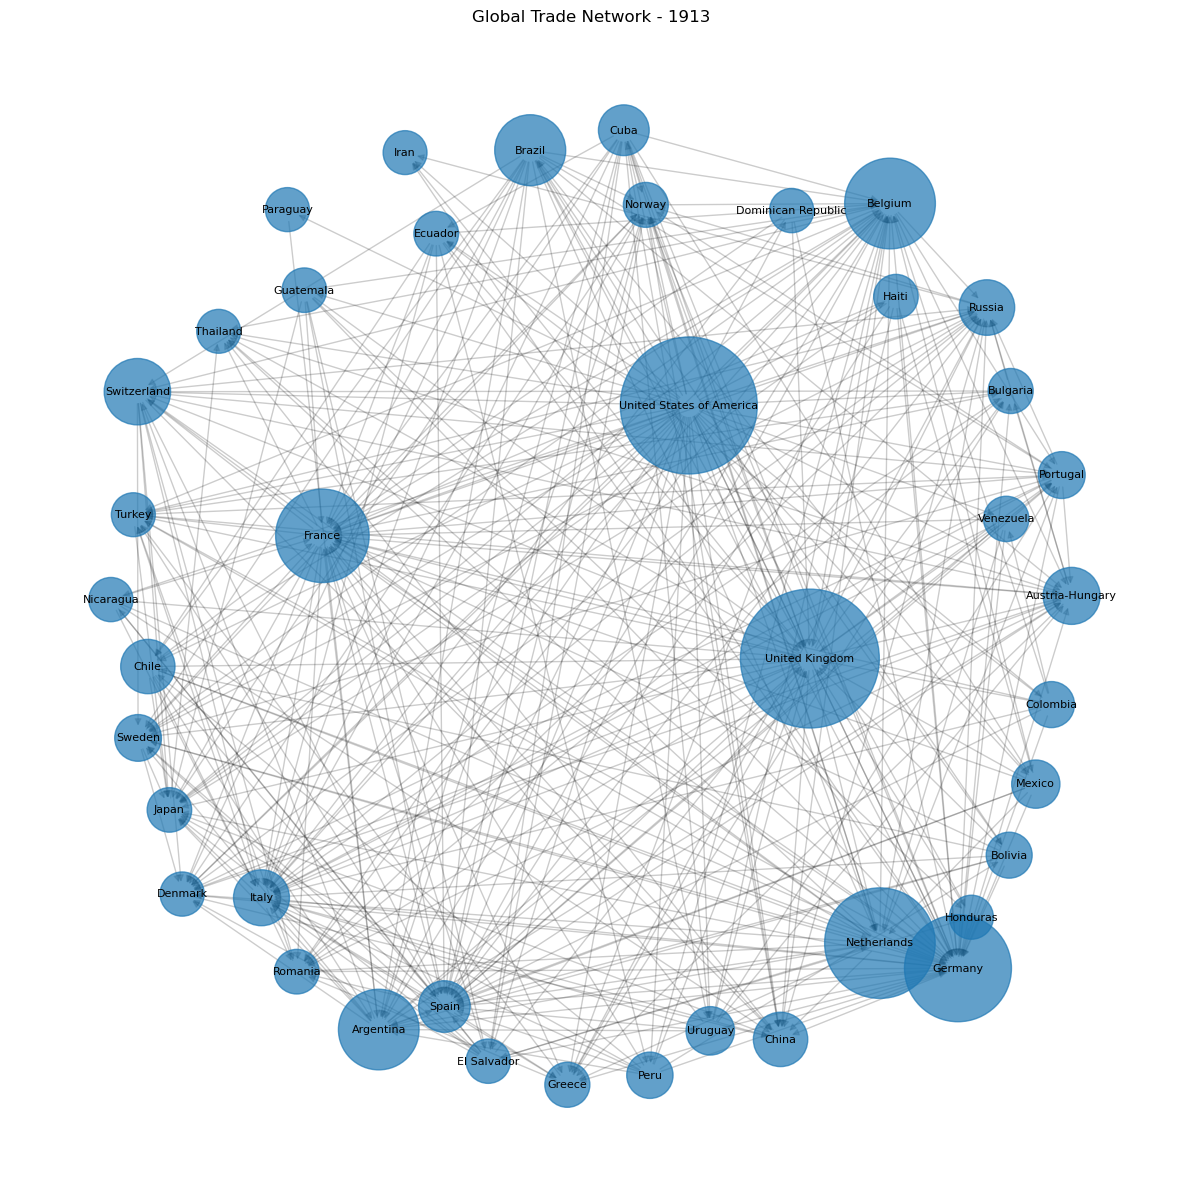

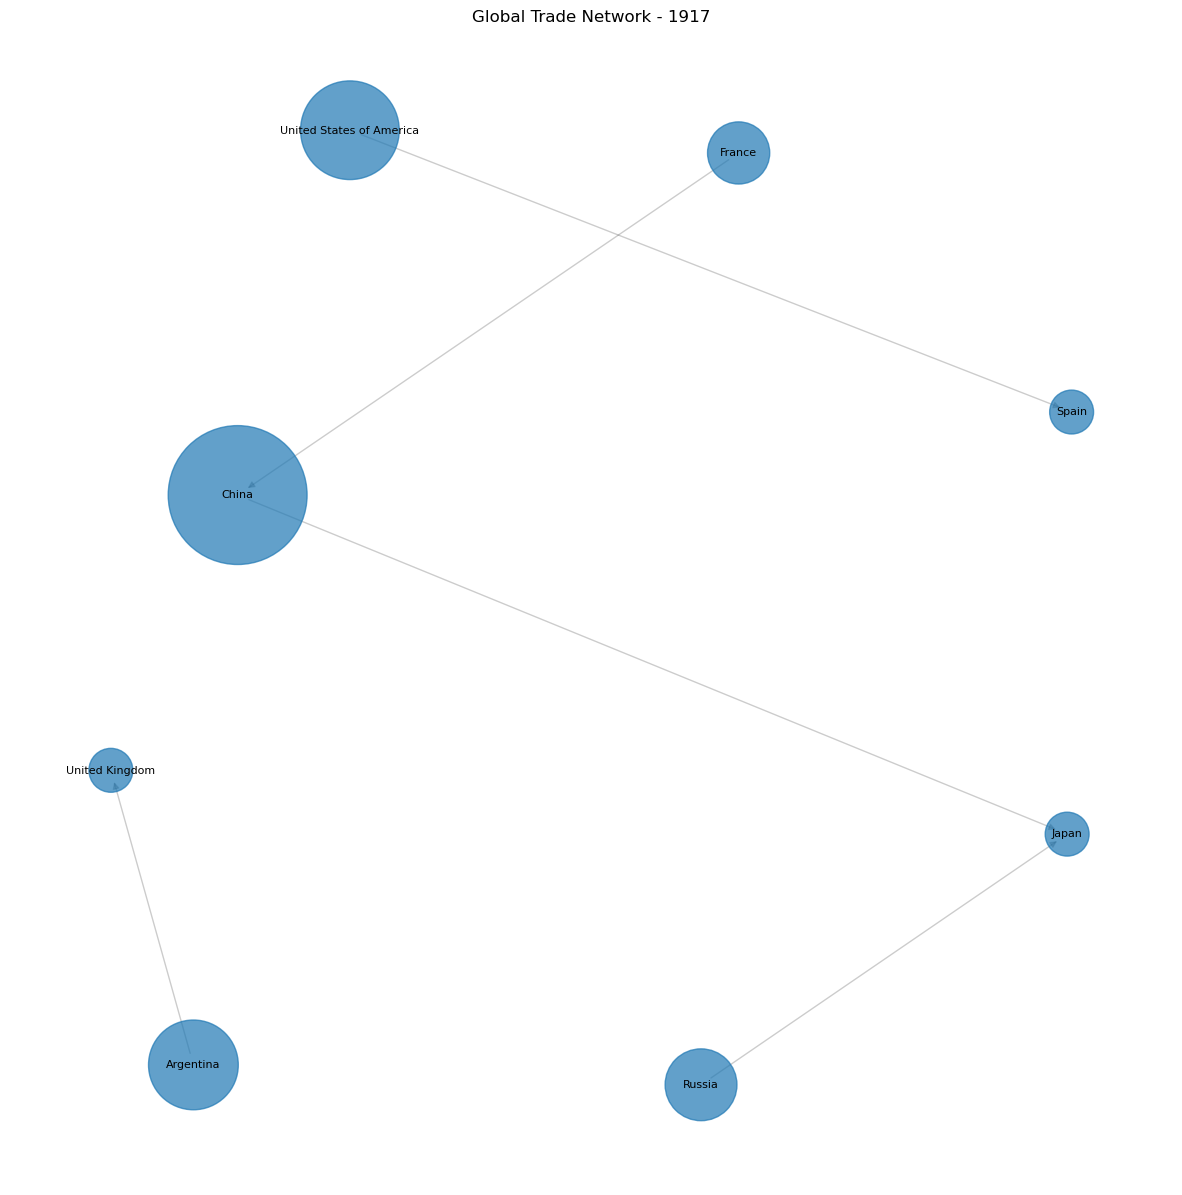

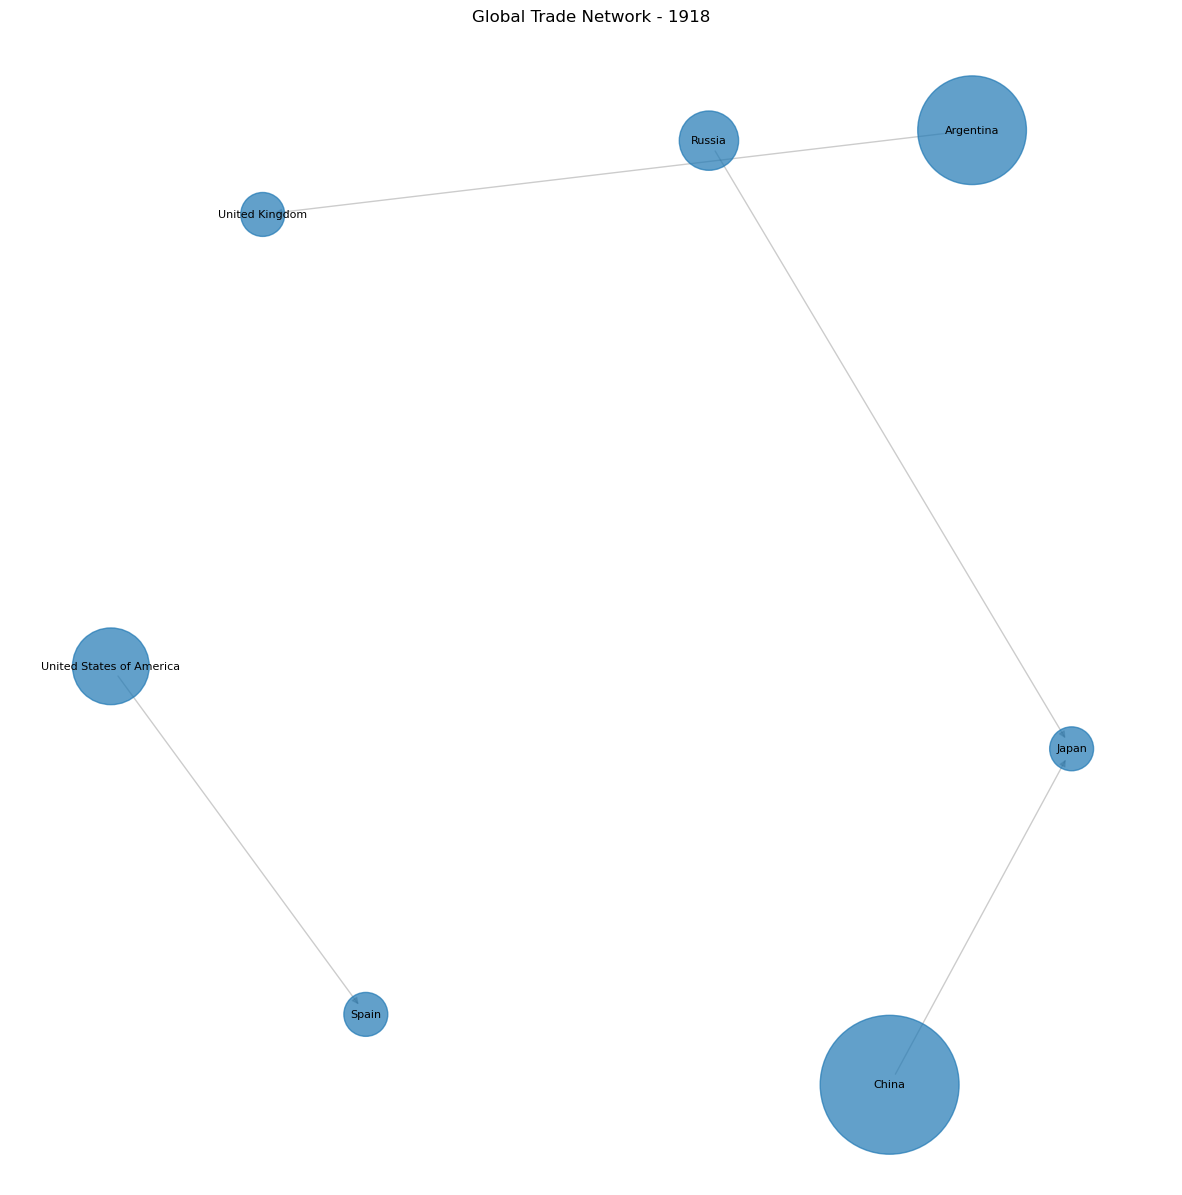

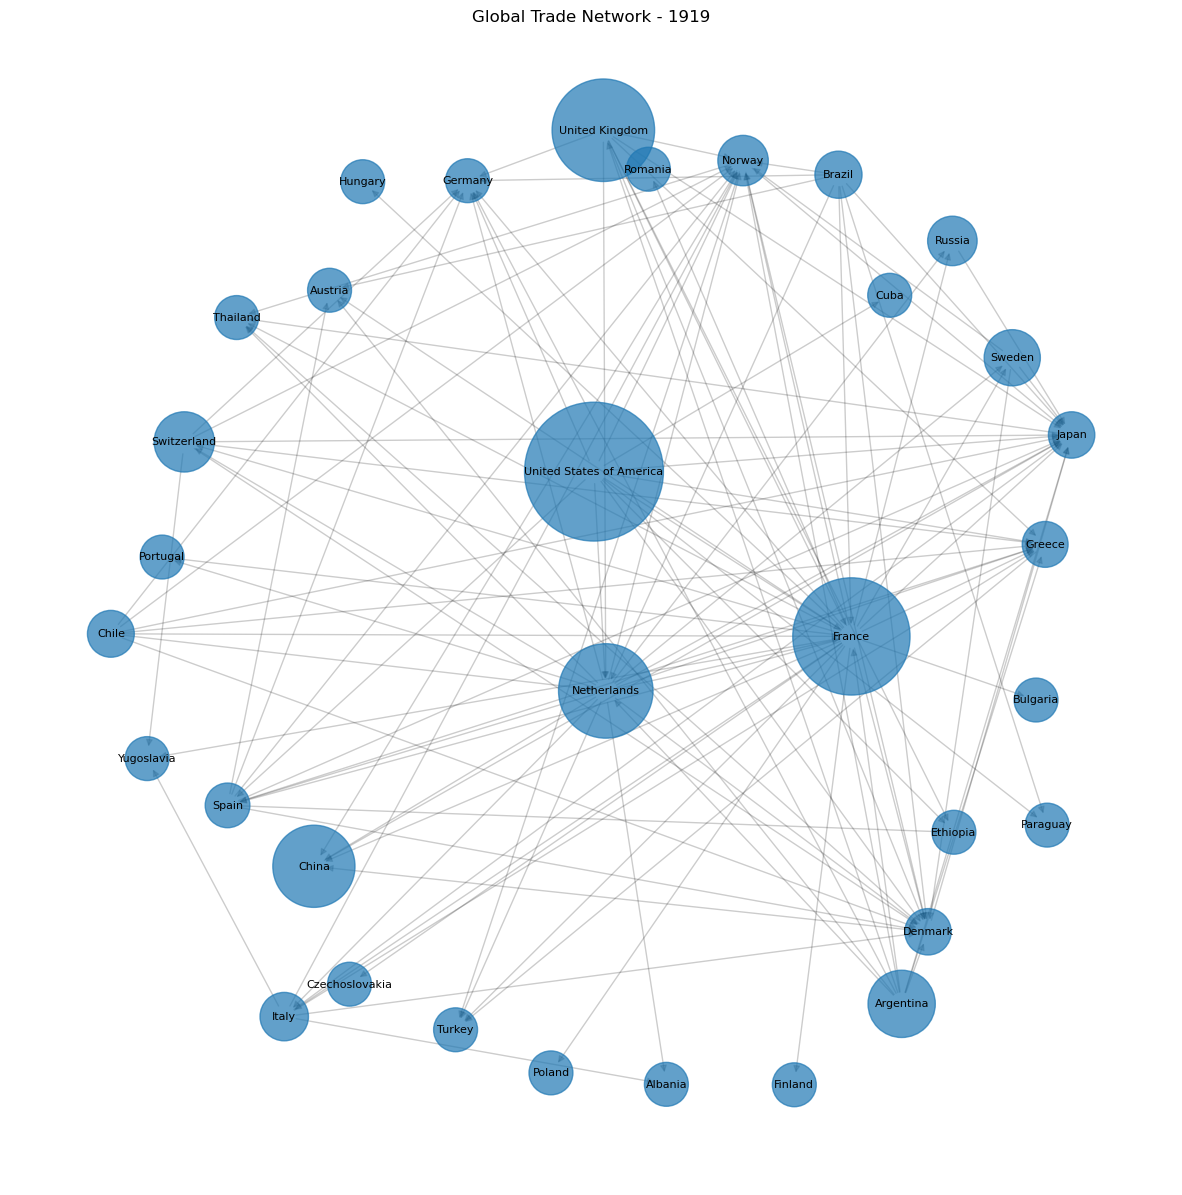

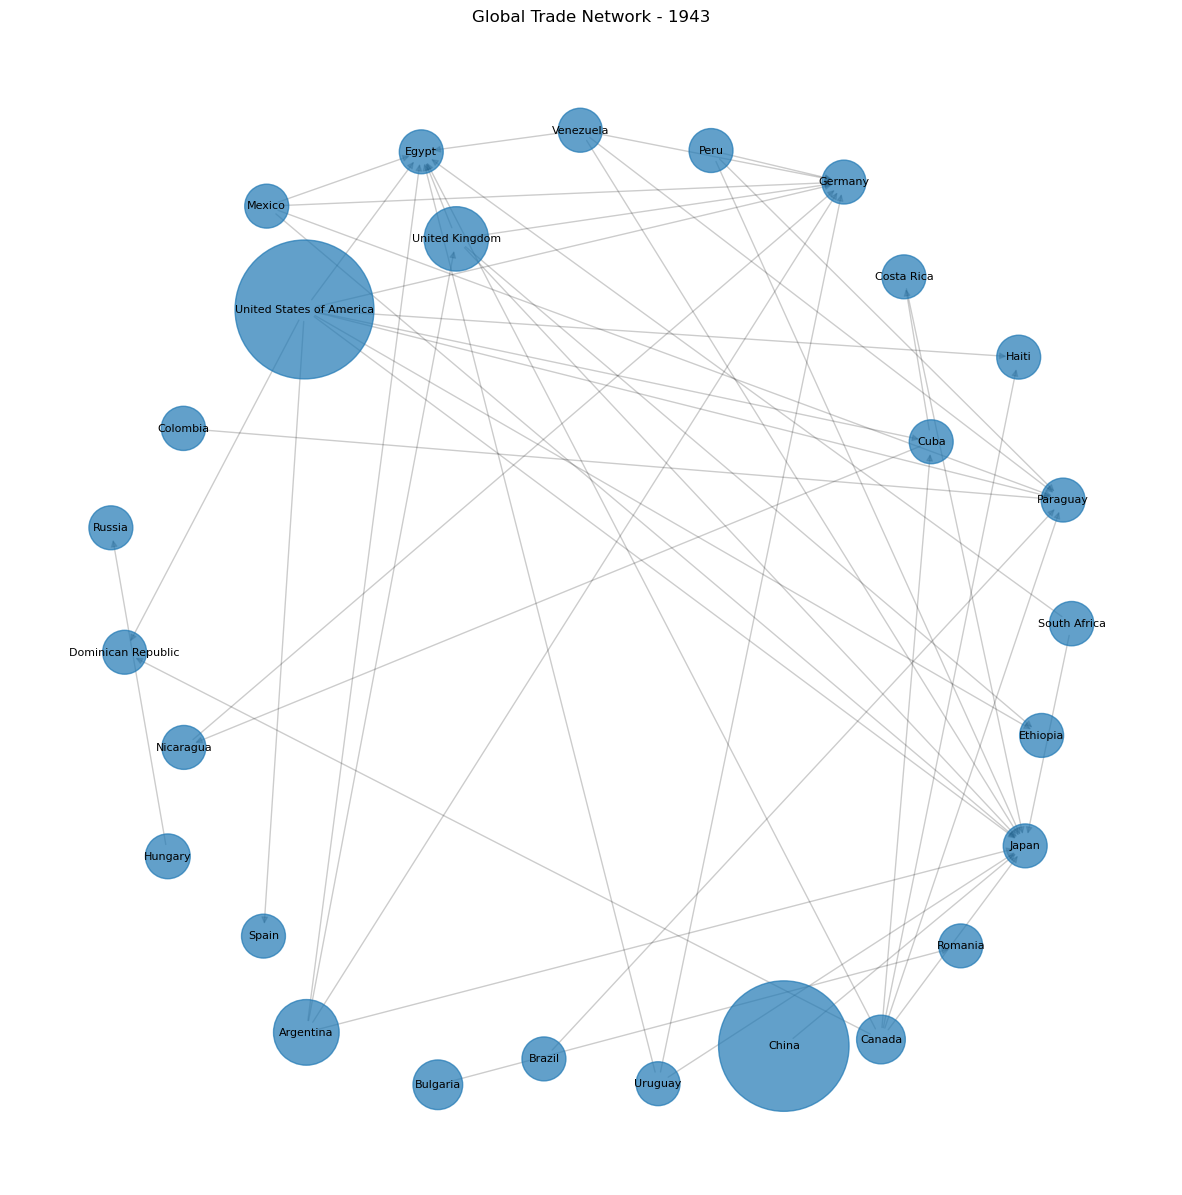

In [72]:
plot_trade_network(df,1913)

plot_trade_network(df,1917)

plot_trade_network(df,1918)
plot_trade_network(df,1919)

plot_trade_network(df,1943)

In [68]:
df[df['year']==1918]

ccode1  ccode2  year                 importer1       importer2  \
4263         2     230  1918  United States of America           Spain   
317409     160     200  1918                 Argentina  United Kingdom   
562377     365     740  1918                    Russia           Japan   
858994     710     740  1918                     China           Japan   

         flow1       flow2  smoothflow1  smoothflow2  smoothtotrade  ...  \
4263     50.00   34.290001    76.127502    69.379997     224.170000  ...   
317409  124.96  305.799990   124.960000   305.799990     430.759980  ...   
562377   20.09    2.520000    26.969999     2.520000      32.267498  ...   
858994  219.50  191.500000   219.500000   191.500000     411.000000  ...   

        dip2  trdspike  tradedip  bel_lux_alt_flow1  bel_lux_alt_flow2  \
4263       1         0         1               -9.0               -9.0   
317409     0         0         0               -9.0               -9.0   
562377     0         0         1               -9.0               -9.0   
858994     0         0         0               -9.0               -9.0   

        china_alt_flow1  china_alt_flow2  source1  source2  version  
4263               -9.0             -9.0      1.0      1.0        4  
317409             -9.0             -9.0      1.0      1.0        4  
562377             -9.0             -9.0      1.0      1.0        4  
858994             -9.0             -9.0      1.0      1.0        4  

[4 rows x 23 columns]